<script type="text/x-mathjax-config">
MathJax.Hub.Config({
  TeX: { equationNumbers: { autoNumber: "AMS" } }
});
</script>

<h1> Latend Dirichlet Allocation (LDA) in python from scratch </h1> 

References:
<ul>
<li>[1] <a href="http://psiexp.ss.uci.edu/research/papers/SteyversGriffithsLSABookFormatted.pdf">Probabilistic Topic Models</a> (Theory)</li>
<li>[2] <a href="http://psiexp.ss.uci.edu/research/papers/sciencetopics.pdf">Finding scientific topics</a> (Theory)</li>
<li>[3] <a href="http://ailab.chonbuk.ac.kr/seminar_board/pds1_files/darling-lda_Collapsed_GIBBS_sampling.pdf">A Theoretical and Practical Implementation Tutorial on Topic Modeling and Gibbs Sampling</a> (Theory and pseudo-code)</li>
<li>[4] <a href="http://brooksandrew.github.io/simpleblog/articles/latent-dirichlet-allocation-under-the-hood/">Latent Dirichlet Allocation - under the hood</a> (Tutorial with code in R)</li>
</ul>

Libraries needed: <i>numpy</i>, <i>pandas</i>, <i>matplotlib</i>, <i>nltk</i> with the package <i>stopwords</i>.

<h3>The goal </h3>

The goal of LDA is, given a set of documents (the <i>corpus</i>), to model the distribution of topics ($\theta$) across the documents and the distribution of words ($\phi$) across topics.

<h3>The input</h3>

For this example I will use 6 sentences (documents) as input. The documents are the following:

<ul>
<li>Doc.0: <i>The dog plays with the cat on the mountain, while the hyppo fights the lion in the forest.</i></li>
<li>Doc.1: <i>in the forest and the jungle, wild cats and lions eat birds' eggs</i></li>
<li>Doc.2: <i>The mountain is full of bears, wolfs, birds and ducks. Fish lay eggs in the river, while cats and hyppos play together</i></li>
<li>Doc.3: <i>I like eggs and waffles for breakfast, but I could eat cheese, pizza and mayo too.</i></li>
<li>Doc.4: <i>Only veggies for lunch, but I am craving pizza and cheese.</i></li>
<li>Doc.5: <i>Let's make fish for dinner, with bread, cheese, fruit, chocolate and gelato for dessert.</i></li>
</ul>

Clearly the first three sentences talk about animals, while the last three about food. Some of the words, e.g. <i>eggs</i>,<i>fish</i> and <i>eat</i>, can be used for both topics.

<h3>1. First things first: cleaning the text</h3>

As a first step we need to "clean" the corpus. What we want to do is:
<ol>
<li>Strip punctuation and transform all characters to lower case;</li>
<li>Split each document in a list of words;</li>
<li>Strip stop words, i.e. words like <i>for,but,in,on,a,the,...</i> which cannot really be associated to any specific topic;</li>
<li>Stem our words (optional);</li>
<li>Select only the most significant words, i.e. the words which appear the most in the corpus (optional, useful with large documents).</li>
</ol>

In what follows I implemented functions to perform steps from 1 to 4. Since we only have 6 sentences, the last step (5) is not necessary and I did not implemented it.

In [1]:
# Import libraries
import string
#from string import maketrans
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from collections import OrderedDict
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *
from matplotlib import rc
import matplotlib.lines as mlines
%matplotlib inline

In [2]:
# Function to clean the corpus: the corpus is a list of documents
def cleanCorpus(corpus,strip_punct=True,strip_stop=True,stem=True):
    # Strip punctuation and transform to lower case
    if (strip_punct):
        corpus = stripPunctuation(corpus)
    # Split each document in the corpus to a list of words
    corpus = splitCorpus(corpus)
    # Strip stop words
    if (strip_stop):
        corpus = stripStopWords(corpus)
    # Stem using snowball stemmer
    if (stem):
        corpus = stemCorpus(corpus)
    
    return corpus
    
# Strip punctuation and special characters
def stripPunctuation(corpus):
    intab = ",.><?:;\"\'[]-_=+)(*&^%$#@!`~/|}{//" # Punctuation table
    outtab = ""
    for c in intab:
        outtab += " "
    doc = []
    translator = str.maketrans(intab, outtab, string.punctuation)
    for d in corpus:
        doc.append(d.translate(translator).lower())
    return doc

# Split the list of documents in a list of lists
def splitCorpus(corpus):
    doc = []
    for d in corpus:
        doc.append(d.split(" "))
    return doc

# Strip stop words from corpus
def stripStopWords(corpus):
    stop = set(stopwords.words('english'))
    doc = []
    for d in corpus:
        doc.append(filter(lambda w: not w in stop,d))
    return doc

# Stem corpus using snowball stemmer
def stemCorpus(corpus):
    stemmer = SnowballStemmer("english")
    doc = []
    for d in corpus: # loop over documents
        dnew = []
        for s in d: # loop over strings in the document
            s = stemmer.stem(s)
            dnew.append(s)
        doc.append(dnew)
    
    return doc

# Convert list of lists in a flat list
def c_flatten(corpus):
    return [w for d in corpus for w in d]

In [3]:
# Create list of documents
doc = []
doc.append("The dog plays with the cat on the mountain, while the hyppo fights the lion in the forest.")
doc.append("in the forest and the jungle, wild cats and lions eat birds' eggs")
doc.append("The mountain is full of bears, wolfs, birds and ducks. Fish lay eggs in the river, while cats and hyppos play together")
doc.append("I like eggs and waffles for breakfast, but I could eat cheese, pizza and mayo too.")
doc.append("Only veggies for lunch, but I am craving pizza and cheese.")
doc.append("Let's make fish for dinner, with bread, cheese, fruit, chocolate and gelato for dessert.")

print (doc)

['The dog plays with the cat on the mountain, while the hyppo fights the lion in the forest.', "in the forest and the jungle, wild cats and lions eat birds' eggs", 'The mountain is full of bears, wolfs, birds and ducks. Fish lay eggs in the river, while cats and hyppos play together', 'I like eggs and waffles for breakfast, but I could eat cheese, pizza and mayo too.', 'Only veggies for lunch, but I am craving pizza and cheese.', "Let's make fish for dinner, with bread, cheese, fruit, chocolate and gelato for dessert."]


In [4]:
# Clean from punctuation, stop words, split and stem
doc = cleanCorpus(doc,stem=True)
print (doc)

[['dog', 'play', 'cat', 'mountain', 'hyppo', 'fight', 'lion', 'forest'], ['forest', 'jungl', 'wild', 'cat', 'lion', 'eat', 'bird', 'egg'], ['mountain', 'full', 'bear', 'wolf', 'bird', 'duck', 'fish', 'lay', 'egg', 'river', 'cat', 'hyppo', 'play', 'togeth'], ['like', 'egg', 'waffl', 'breakfast', 'could', 'eat', 'chees', 'pizza', 'mayo'], ['veggi', 'lunch', 'crave', 'pizza', 'chees'], ['let', 'make', 'fish', 'dinner', 'bread', 'chees', 'fruit', 'chocol', 'gelato', 'dessert']]


<h3> 2. The Dirichlet distribution </h3>

The distributions of topics and words can be modeled using a Dirichlet distribution. The probability density of a $T$ dimensional Dirichlet distribution over the multinomial distribution $p=(p_1,p_2,...,p_T)$ is defined by <a href="http://psiexp.ss.uci.edu/research/papers/SteyversGriffithsLSABookFormatted.pdf">[1]</a>:

\begin{align}\tag{1}
\textrm{Dir}(\alpha_1,...,\alpha_T)= \frac{\Gamma\left(\sum_j\alpha_j\right)}{\prod_j\Gamma\left(\alpha_j\right)}\prod_{j=1}^{T}p_j^{\alpha_j-1},
\end{align}

where $\Gamma$ is the gamma function. In our case we will also use a symmetric Dirichlet distribution, meaning that we choose the concentration (hyper)parameter $\alpha=\alpha_1=...=\alpha_T$. 

Below we can see how the Dirichled distribution varies when changing the concentration parameter.


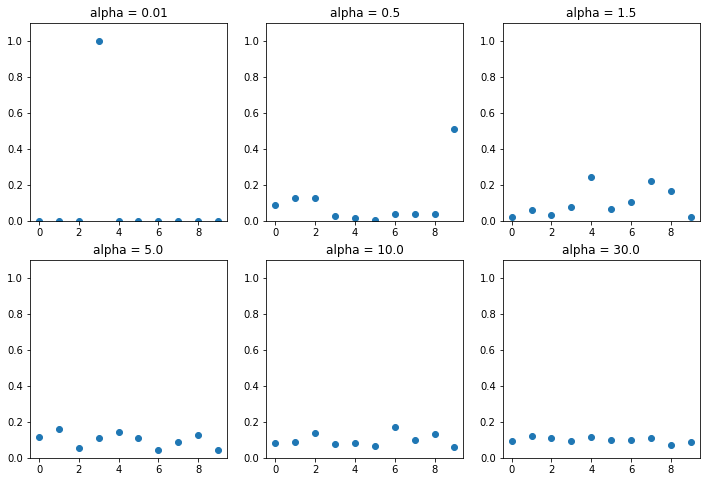

In [5]:
# Experiment with dirichlet distribution

# Here I plot a dirichlet distribution for 10 topics varying the concentration parameter alpha
T = 10
np.random.seed(123)

fig = figure(figsize=(12,8))
for i,alpha in enumerate([0.01,0.5,1.5,5.0,10.0,30.0]):
    prob =  np.random.dirichlet(alpha * np.ones(T)).transpose()
    sub = fig.add_subplot(2,3,i+1)
    sub.plot(np.arange(T),prob,lw=0.0,marker='o')
    sub.set_title("alpha = " + str(alpha))
    sub.set_ylim([0,1.1])
    
plt.show()

For small values of $\alpha$, the probability is fragmented and certain topics have very high probability, while most of them have close to zero probability. Increasing $\alpha$, the distribution flattens and becomes more uniform. Because of the nature of the generative process of documents <a href="http://psiexp.ss.uci.edu/research/papers/SteyversGriffithsLSABookFormatted.pdf">[1</a>,<a href="http://psiexp.ss.uci.edu/research/papers/sciencetopics.pdf">2]</a>, when using Dirichlet distributions we will use small concentration parameters.

<h3> 3. "Tokenizing" the corpus </h3>

Working with indices is easier than working with words. Here we count all the unique words in the corpus and we assign to each unique word an integer index. We basically build a dictionary (or mapping) between words and integers.

In [6]:
# Assign a token number to each unique word
# Count unique words and setup index dictionary
bag_words = c_flatten(doc)
index_dict = OrderedDict()
i = 0
for w in bag_words:
    if (w not in index_dict):
        index_dict[w] = i
        i += 1 
print ("Total number of words: " + str(len(bag_words)))
print ("Total number of unique words: " + str(len(index_dict)))


Total number of words: 54
Total number of unique words: 39


Tokenize the corpus: substitute each word with the corresponding index value.

In [7]:
# Tokenize corpus
doc_tokenized = []
for d in doc:
    d_new = []
    for w in d:
        d_new.append(index_dict[w])
    doc_tokenized.append(d_new)
print(doc_tokenized)

[[0, 1, 2, 3, 4, 5, 6, 7], [7, 8, 9, 2, 6, 10, 11, 12], [3, 13, 14, 15, 11, 16, 17, 18, 12, 19, 2, 4, 1, 20], [21, 12, 22, 23, 24, 10, 25, 26, 27], [28, 29, 30, 26, 25], [31, 32, 17, 33, 34, 25, 35, 36, 37, 38]]


<h3> 4. Build the word-topic and document-topic matrices </h3>

By following Ref.<a href="http://psiexp.ss.uci.edu/research/papers/SteyversGriffithsLSABookFormatted.pdf">[1]</a> we need to define three objects matrices:
<ul>
<li>The word-topic $C^{WT}\in \mathbb{N}^{T\times W}$ matrix, which for each word (column) counts how many times that word has been assigned to a given topic (row). </li>
<li>The word-topic $C^{DT}\in \mathbb{N}^{D\times T}$ matrix, which for each document (row) counts by how many words a topic (column) is represented in the document itself. </li>
<li>The assignment list $\mathbf{z}$, where substitute each word in the corpus with the given topic assignment.</li>
</ul>

Here, $W$ is the number of unique words, $T$ is the number of topics and $D$ is the number of documents in the corpus.



In [8]:
# Initialize word-topic (WT) matrix and topic assignment list z
T = 2 # topics number
W = len(index_dict) # Total number of unique words
alpha = 0.01 #50.0 / T
beta = 0.01
WT = np.zeros((T,len(index_dict)),dtype=int) 
z = []
for d in doc:
    d_new = []
    for w in d:
        # Find token associated with word
        widx = index_dict[w]
        # Pick a topic for the word randomly
        k = np.argmax(np.random.dirichlet(beta * np.ones(T)))
        # Update assignment list
        d_new.append(k)
        # Update word-topic matrix
        WT[k,widx] += 1
    # Update assignment list
    z.append(d_new)

In [9]:
# Initialize document-topic (DT) matrix
DT = np.zeros((len(doc),T),dtype=int)
for didx,d in enumerate(doc):
    for k in range(T):
        for i in z[didx]:
            if (i == k):
                DT[didx,k] += 1

<h3> 5. The LDA algorithm </h3>

We can finally implement the LDA algorithm from Ref.<a href="http://ailab.chonbuk.ac.kr/seminar_board/pds1_files/darling-lda_Collapsed_GIBBS_sampling.pdf">[3]</a>, where using Gibbs sampling, and iterating over the words in the corpus, we update the posterior probability of a word $i$ to be assigned to a topic $j$:

\begin{align}\tag{2}
\mathbb{P}\left(z_i=j|\mathbf{z}_{-i},w_i,d_i,\alpha,\beta\right) \propto \frac{C_{w_ij}^{WT} + \beta}{\sum_{w=1}^WC^{WT}_{wj} + W\beta}\frac{C^{DT}_{dj} + \alpha}{\sum_{t=1}^TC^{DT}_{dt}+T\alpha}
\end{align}

In [10]:
# Maximum number of iterations
iterMax = 5000

for i in range(iterMax):
    for didx,d in enumerate(doc):
        for wi,w in enumerate(d):
            # Find topic of the word w
            topic = z[didx][wi]
            # Decrease counter matrices (exclute token w from them)
            widx = index_dict[w]
            WT[topic,widx] -= 1
            DT[didx,topic] -= 1
            # Update topic assignment for each word:
            # Calculate posterior probability p_z
            pz = []
            for k in range(T):
                den_right = T * alpha + np.sum(DT[didx,:])
                den_left = W * beta + np.sum(WT[k,:])
                left = (WT[k,widx] + beta) / den_left
                right = (DT[didx,k] + alpha) / den_right
                pz.append(left * right)
            # Normalize posterior
            pz = pz / np.sum(pz)
            # Sample new topic from posterior
            new_topic = np.random.choice(np.arange(T),p=pz)
            z[didx][wi] = new_topic
            # Update the counter matrices
            WT[new_topic,widx] += 1
            DT[didx,new_topic] += 1

<h3> 6. Estimate $\theta$ and $\phi$ </h3>

Having the updated word-topic and document-topic matrices, we can now calculate the word-topic ($\phi$) and topic-document ($\theta$) distributions via

\begin{align}
\tag{3}
\phi^{(j)}_i =& \frac{C^{WT}_{ij}+\beta}{\sum_{j=1}^WC^{WT}_{kj}+W\beta}\\
\tag{4}
\theta^{(d)}_j =& \frac{C^{DT}_{dj}+\alpha}{\sum_{j=1}^TC^{DT}_{dk}+T\alpha}
\end{align}

In [11]:
theta = (DT + alpha)
for d in range(DT.shape[0]):
    theta[d,:] = theta[d,:] / (np.sum(DT[d,:]) + T * alpha)
phi = (WT + beta)
for k in range(T):
    phi[k,:] = phi[k,:] / (np.sum(WT[k,:]) + W * beta)

We can visualize the distributions to get a better idea of what the LDA algorithm found.

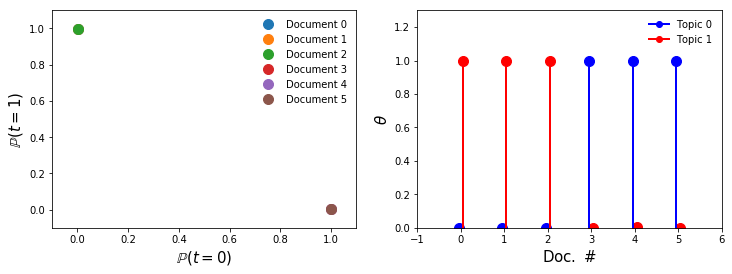

In [12]:
# Visualize theta distribution (topics distribution amongst documents)
fig = figure(figsize=(12,4))

sub = fig.add_subplot(121)
for didx in range(len(doc)):
    sub.plot(theta[didx,0],theta[didx,1],label="Document " + str(didx),
            marker='o',lw=0.0,markersize=10)
sub.set_xlabel("$\mathbb{P}(t=0)$",fontsize=15)
sub.set_ylabel("$\mathbb{P}(t=1)$",fontsize=15)
sub.legend(numpoints=1,loc="upper right",frameon=False,fontsize=10)
sub.set_xlim([-0.1,1.1])
sub.set_ylim([-0.1,1.1])

# Theta distribution of topic 0
sub = fig.add_subplot(122)
for i in range(len(doc)):
    sub.plot(i-0.05,theta[i,0],lw=0.0,color='blue',
        marker='o',markersize=10)
    sub.plot(i+0.05,theta[i,1],lw=0.0,color='red',
        marker='o',markersize=10)
    sub.plot([i-0.05,i-0.05],[0,theta[i,0]],color='blue',
            lw=2.0)
    sub.plot([i+0.05,i+0.05],[0,theta[i,1]],color='red',
            lw=2.0)
sub.set_xlabel("$\\rm{Doc.\ \#}$",fontsize=15)
sub.set_ylabel("$\\theta$",fontsize=15)
sub.set_xlim([-1,len(doc)])
sub.set_ylim([0.0,1.3])

t0 = mlines.Line2D([], [], lw=2.0 ,marker='o', color='blue', label='Topic 0')
t1 = mlines.Line2D([], [], lw=2.0 ,marker='o', color='red', label='Topic 1')
sub.legend(numpoints=1,loc="upper right",handles=[t0,t1],frameon=False,fontsize=10)


plt.show()

The LDA algorithm classifies correctly all the 6 sentences. The first three are classified as "Topic 0" (animals) and the last three as "Topic 1" (food).

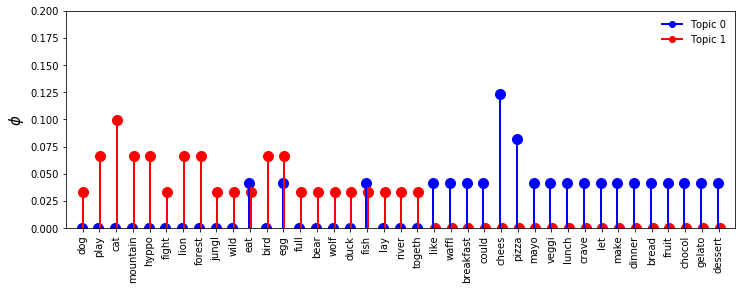

In [13]:
# Visualize words distribution across topics
fig = figure(figsize=(12,4))

# Theta distribution of topic 0
sub = fig.add_subplot(111)
for i in range(phi.shape[1]):
    sub.plot(i-0.05,phi[0,i],lw=0.0,color='blue',
        marker='o',markersize=10)
    sub.plot(i+0.05,phi[1,i],lw=0.0,color='red',
        marker='o',markersize=10)
    sub.plot([i-0.05,i-0.05],[0,phi[0,i]],color='blue',
            lw=2.0)
    sub.plot([i+0.05,i+0.05],[0,phi[1,i]],color='red',
            lw=2.0)

ticks_labels = index_dict.keys() #sub.text(i,top+0.02,index_dict.keys()[i],rotation=90)
sub.set_xticks(np.arange(len(ticks_labels)))
sub.set_xticklabels(ticks_labels,rotation=90)

sub.set_ylabel("$\\phi$",fontsize=15)
sub.set_xlim([-1,phi.shape[1]])
sub.set_ylim([0.0,0.2])

t0 = mlines.Line2D([], [], lw=2.0 ,marker='o', color='blue', label='Topic 0')
t1 = mlines.Line2D([], [], lw=2.0 ,marker='o', color='red', label='Topic 1')
sub.legend(numpoints=1,loc="upper right",handles=[t0,t1],frameon=False,fontsize=10)


plt.show()

The red identifies the animal topic, while the blue the food topic. As we pointed out at the beginning, there where three words that were used for both topics: eggs, eat and fish. The LDA algorithm has been able to identify these words and it assigned a probability to belong to both the topics different from zero!